# Import

In [ ]:
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from joblib import dump, load

# Data importeren

Importeren van de data uit drive,
vul de authorization code in die verkregen wordt via de link of er wordt al direct een scherm opgebracht waar je kan inloggen.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/datasets" "/content/datasets"

Mounted at /gdrive


In [ ]:
import shutil
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_400_100_100.zip','.','zip')

# creëren datasets

Bij het creëren van deze datasets moet de class_mode verandert naar categorical omdat we nu met multi class data werken (3 verschillende labels).

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 1200 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

# EfficientNet normale augmentatie

Omdat we nu werken met multi-class classification voegen we 2 velden toe wanneer we het model creëren, deze velden zijn classes en classifier_activation.

* classes staat voor hoeveel klassen het model moet classificeren.
* classifier_activation is de manier waarop de data geclassificeerd zal worden.

In [ ]:
base_model = keras.applications.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

Doordat we nu werken met multi class bestaat de output uit 3 waarden, dus moeten we de dense aanpassen naar:

```
Dense(3, activation="softmax")(x)
```



In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

Ik heb hier ook de loss verandert naar een categorical_crossentropy 

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

Het trainen van dit model duurt veel langer dan de vorige modellen, daarom gebruiken we maar een aantal epochs van 40.

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 12.4114 - accuracy: 0.7908

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 26s 363ms/step - loss: 12.4114 - accuracy: 0.7908 - val_loss: 15.0976 - val_accuracy: 0.7500
Epoch 2/30
38/38 [==============================] - 10s 241ms/step - loss: 5.8474 - accuracy: 0.8675 - val_loss: 10.1187 - val_accuracy: 0.8333
Epoch 3/30
38/38 [==============================] - 10s 240ms/step - loss: 2.3676 - accuracy: 0.9358 - val_loss: 9.4374 - val_accuracy: 0.8667
Epoch 4/30
38/38 [==============================] - 10s 242ms/step - loss: 3.1137 - accuracy: 0.9208 - val_loss: 6.8930 - val_accuracy: 0.8933
Epoch 5/30
38/38 [==============================] - 9s 221ms/step - loss: 2.7178 - accuracy: 0.9367 - val_loss: 8.1224 - val_accuracy: 0.9033
Epoch 6/30
38/38 [==============================] - 10s 227ms/step - loss: 2.2903 - accuracy: 0.9433 - val_loss: 10.4550 - val_accuracy: 0.8467
Epoch 7/30
38/38 [==============================] - 9s 221ms/step - loss: 2.4479 - accuracy: 0.9425 - val_loss: 8.9105 - val_accuracy: 0.8767
Epoch 8/

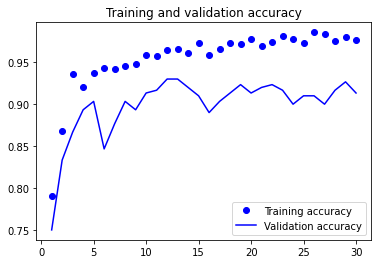

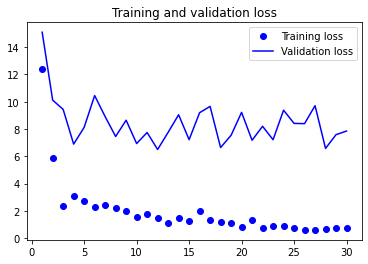

In [ ]:
import matplotlib.pylab as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 130ms/step - loss: 5.6864 - accuracy: 0.9033
Test accuracy: 0.903


We zien dat de accuracy al heel wat daalt door te veranderen van binaire classifcatie naar multi class classification, wat wel logisch is.

We kunnen nu eens testen wat het verschil is wanneer we een andere optimizer gebruiken, zoals adam en sgd.

# EfficientNet zonder augmentatie

https://medium.com/@yanahalas/aesthetic-deep-learning-identifying-the-artist-from-the-artwork-45176c1b2743

In [ ]:
base_model = keras.applications.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.6077 - accuracy: 0.8333

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 18s 276ms/step - loss: 0.6077 - accuracy: 0.8333 - val_loss: 0.4621 - val_accuracy: 0.9067
Epoch 2/30
38/38 [==============================] - 10s 239ms/step - loss: 0.0789 - accuracy: 0.9725 - val_loss: 0.4090 - val_accuracy: 0.9167
Epoch 3/30
38/38 [==============================] - 9s 212ms/step - loss: 0.0359 - accuracy: 0.9875 - val_loss: 0.4103 - val_accuracy: 0.9167
Epoch 4/30
38/38 [==============================] - 9s 225ms/step - loss: 0.0355 - accuracy: 0.9875 - val_loss: 0.3697 - val_accuracy: 0.9167
Epoch 5/30
38/38 [==============================] - 9s 225ms/step - loss: 0.0198 - accuracy: 0.9933 - val_loss: 0.3591 - val_accuracy: 0.9333
Epoch 6/30
38/38 [==============================] - 9s 227ms/step - loss: 0.0203 - accuracy: 0.9942 - val_loss: 0.3533 - val_accuracy: 0.9200
Epoch 7/30
38/38 [==============================] - 9s 226ms/step - loss: 0.0149 - accuracy: 0.9967 - val_loss: 0.3517 - val_accuracy: 0.9200
Epoch 8/30
38/3

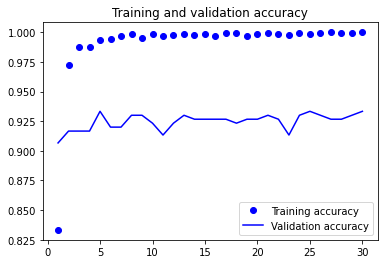

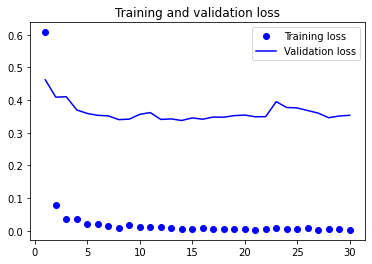

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 127ms/step - loss: 0.3024 - accuracy: 0.9033
Test accuracy: 0.903


# ResNet50 normale augmentatie

Hier ga ik nu gebruik maken van het pretrained convnet ResNet, voor de rest blijft de manier van werken gelijk aan het vorige model (VGG16).

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.6132 - accuracy: 0.8292

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 30s 407ms/step - loss: 0.6132 - accuracy: 0.8292 - val_loss: 1.2982 - val_accuracy: 0.8267
Epoch 2/30
38/38 [==============================] - 14s 342ms/step - loss: 0.2277 - accuracy: 0.9242 - val_loss: 0.7820 - val_accuracy: 0.8533
Epoch 3/30
38/38 [==============================] - 15s 354ms/step - loss: 0.1859 - accuracy: 0.9383 - val_loss: 0.4764 - val_accuracy: 0.9167
Epoch 4/30
38/38 [==============================] - 14s 340ms/step - loss: 0.1034 - accuracy: 0.9575 - val_loss: 0.4295 - val_accuracy: 0.9233
Epoch 5/30
38/38 [==============================] - 16s 384ms/step - loss: 0.1191 - accuracy: 0.9575 - val_loss: 0.4701 - val_accuracy: 0.9000
Epoch 6/30
38/38 [==============================] - 16s 374ms/step - loss: 0.0946 - accuracy: 0.9650 - val_loss: 0.4559 - val_accuracy: 0.9100
Epoch 7/30
38/38 [==============================] - 16s 385ms/step - loss: 0.0699 - accuracy: 0.9708 - val_loss: 0.4214 - val_accuracy: 0.9033
Epoch 8/30

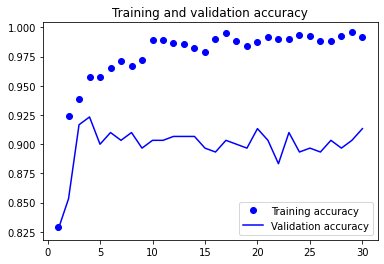

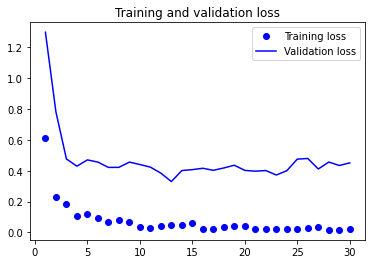

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 5s 197ms/step - loss: 0.1533 - accuracy: 0.9567
Test accuracy: 0.957


# ResNet50 zonder augmentatie

https://medium.com/@yanahalas/aesthetic-deep-learning-identifying-the-artist-from-the-artwork-45176c1b2743

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.5703 - accuracy: 0.8600

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 18s 353ms/step - loss: 0.5703 - accuracy: 0.8600 - val_loss: 0.4275 - val_accuracy: 0.9200
Epoch 2/30
38/38 [==============================] - 14s 330ms/step - loss: 0.0709 - accuracy: 0.9750 - val_loss: 0.3089 - val_accuracy: 0.9267
Epoch 3/30
38/38 [==============================] - 13s 317ms/step - loss: 0.0242 - accuracy: 0.9925 - val_loss: 0.2664 - val_accuracy: 0.9233
Epoch 4/30
38/38 [==============================] - 12s 293ms/step - loss: 0.0228 - accuracy: 0.9900 - val_loss: 0.2717 - val_accuracy: 0.9267
Epoch 5/30
38/38 [==============================] - 12s 297ms/step - loss: 0.0151 - accuracy: 0.9958 - val_loss: 0.2958 - val_accuracy: 0.9267
Epoch 6/30
38/38 [==============================] - 12s 299ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.2770 - val_accuracy: 0.9300
Epoch 7/30
38/38 [==============================] - 12s 294ms/step - loss: 0.0069 - accuracy: 0.9983 - val_loss: 0.2742 - val_accuracy: 0.9267
Epoch 8/30

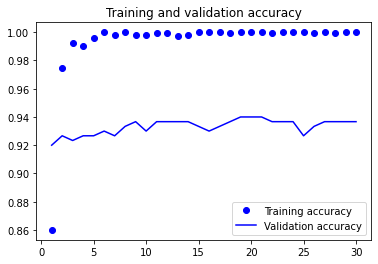

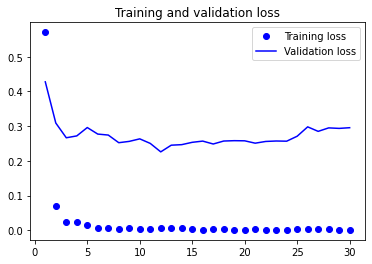

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 194ms/step - loss: 0.1207 - accuracy: 0.9567
Test accuracy: 0.957


# ResNet50 contrast augmentatie

Hier ga ik nu gebruik maken van het pretrained convnet ResNet, voor de rest blijft de manier van werken gelijk aan het vorige model (VGG16).

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomContrast(0.5,1.5)])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.8308

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 19s 348ms/step - loss: 0.5784 - accuracy: 0.8308 - val_loss: 0.6032 - val_accuracy: 0.9133
Epoch 2/30
38/38 [==============================] - 13s 318ms/step - loss: 0.0883 - accuracy: 0.9708 - val_loss: 0.3053 - val_accuracy: 0.9100
Epoch 3/30
38/38 [==============================] - 13s 318ms/step - loss: 0.0481 - accuracy: 0.9842 - val_loss: 0.2683 - val_accuracy: 0.9267
Epoch 4/30
38/38 [==============================] - 12s 299ms/step - loss: 0.0349 - accuracy: 0.9858 - val_loss: 0.3367 - val_accuracy: 0.9167
Epoch 5/30
38/38 [==============================] - 13s 314ms/step - loss: 0.0253 - accuracy: 0.9900 - val_loss: 0.2809 - val_accuracy: 0.9267
Epoch 6/30
38/38 [==============================] - 13s 318ms/step - loss: 0.0179 - accuracy: 0.9925 - val_loss: 0.2483 - val_accuracy: 0.9333
Epoch 7/30
38/38 [==============================] - 13s 302ms/step - loss: 0.0165 - accuracy: 0.9958 - val_loss: 0.2768 - val_accuracy: 0.9267
Epoch 8/30

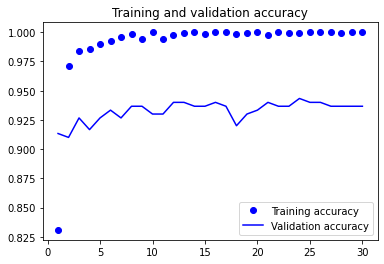

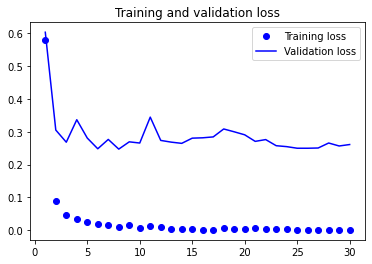

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 205ms/step - loss: 0.0953 - accuracy: 0.9633
Test accuracy: 0.963


# ResNet50 normaal en contrast augmentatie

Hier ga ik nu gebruik maken van het pretrained convnet ResNet, voor de rest blijft de manier van werken gelijk aan het vorige model (VGG16).

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
     layers.RandomContrast(0.5,1.5)])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.8192

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 31s 437ms/step - loss: 0.6919 - accuracy: 0.8192 - val_loss: 1.0336 - val_accuracy: 0.8467
Epoch 2/30
38/38 [==============================] - 14s 356ms/step - loss: 0.2635 - accuracy: 0.9200 - val_loss: 0.7219 - val_accuracy: 0.8600
Epoch 3/30
38/38 [==============================] - 15s 360ms/step - loss: 0.1866 - accuracy: 0.9408 - val_loss: 0.3835 - val_accuracy: 0.9067
Epoch 4/30
38/38 [==============================] - 15s 361ms/step - loss: 0.1532 - accuracy: 0.9517 - val_loss: 0.3521 - val_accuracy: 0.9267
Epoch 5/30
38/38 [==============================] - 15s 360ms/step - loss: 0.1154 - accuracy: 0.9617 - val_loss: 0.3421 - val_accuracy: 0.9300
Epoch 6/30
38/38 [==============================] - 14s 340ms/step - loss: 0.0777 - accuracy: 0.9708 - val_loss: 0.3792 - val_accuracy: 0.9200
Epoch 7/30
38/38 [==============================] - 14s 341ms/step - loss: 0.0947 - accuracy: 0.9675 - val_loss: 0.3514 - val_accuracy: 0.9133
Epoch 8/30

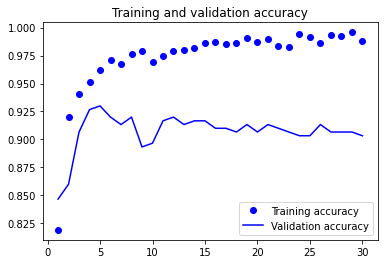

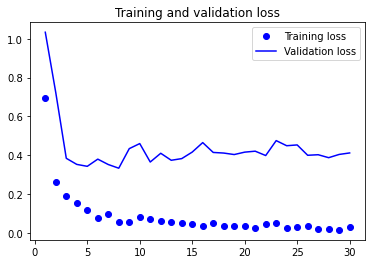

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 212ms/step - loss: 0.1610 - accuracy: 0.9467
Test accuracy: 0.947


# ResNet50 translation augmentatie

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2)])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.8200

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 20s 387ms/step - loss: 0.7128 - accuracy: 0.8200 - val_loss: 1.2005 - val_accuracy: 0.8200
Epoch 2/30
38/38 [==============================] - 14s 353ms/step - loss: 0.2333 - accuracy: 0.9242 - val_loss: 0.5159 - val_accuracy: 0.9067
Epoch 3/30
38/38 [==============================] - 14s 356ms/step - loss: 0.1671 - accuracy: 0.9467 - val_loss: 0.4559 - val_accuracy: 0.9067
Epoch 4/30
38/38 [==============================] - 14s 354ms/step - loss: 0.1077 - accuracy: 0.9592 - val_loss: 0.3522 - val_accuracy: 0.9067
Epoch 5/30
38/38 [==============================] - 15s 367ms/step - loss: 0.1080 - accuracy: 0.9675 - val_loss: 0.3254 - val_accuracy: 0.9133
Epoch 6/30
38/38 [==============================] - 14s 333ms/step - loss: 0.0978 - accuracy: 0.9600 - val_loss: 0.4412 - val_accuracy: 0.8867
Epoch 7/30
38/38 [==============================] - 14s 336ms/step - loss: 0.0686 - accuracy: 0.9767 - val_loss: 0.3556 - val_accuracy: 0.9033
Epoch 8/30

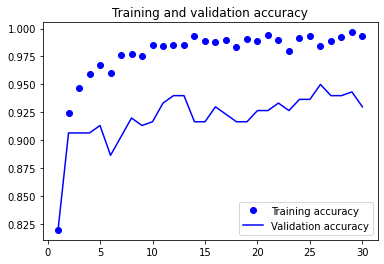

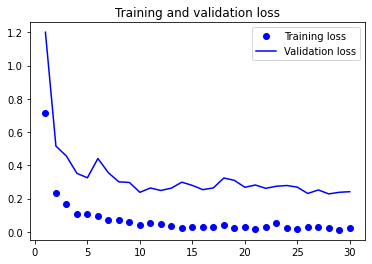

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 206ms/step - loss: 0.1001 - accuracy: 0.9600
Test accuracy: 0.960


# ResNet50 contrast en translation augmentatie

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.8250

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 20s 389ms/step - loss: 0.7403 - accuracy: 0.8250 - val_loss: 0.7518 - val_accuracy: 0.8667
Epoch 2/30
38/38 [==============================] - 15s 359ms/step - loss: 0.2672 - accuracy: 0.9217 - val_loss: 0.4413 - val_accuracy: 0.9000
Epoch 3/30
38/38 [==============================] - 15s 358ms/step - loss: 0.1765 - accuracy: 0.9425 - val_loss: 0.3983 - val_accuracy: 0.9100
Epoch 4/30
38/38 [==============================] - 14s 357ms/step - loss: 0.1696 - accuracy: 0.9458 - val_loss: 0.3000 - val_accuracy: 0.9333
Epoch 5/30
38/38 [==============================] - 14s 355ms/step - loss: 0.1090 - accuracy: 0.9633 - val_loss: 0.2793 - val_accuracy: 0.9300
Epoch 6/30
38/38 [==============================] - 14s 348ms/step - loss: 0.0942 - accuracy: 0.9650 - val_loss: 0.2804 - val_accuracy: 0.9300
Epoch 7/30
38/38 [==============================] - 14s 357ms/step - loss: 0.0887 - accuracy: 0.9717 - val_loss: 0.2382 - val_accuracy: 0.9433
Epoch 8/30

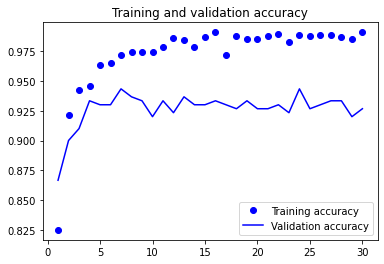

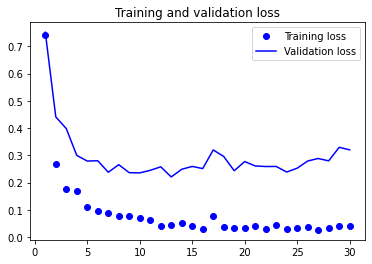

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 205ms/step - loss: 0.0854 - accuracy: 0.9733
Test accuracy: 0.973


#Besluit

* EfficientNet normale augmentatie: accuracy=90.33%
* EfficientNet zonder augmentatie: accuracy=90.33%
* ResNet50 normale augmentatie: accuracy=94%
* ResNet50 zonder augmentatie: accuracy=95%
* ResNet50 contrast augmentatie: accuracy=96.33%
* ResNet50 combinatie normaal en contrast augmentatie: accuracy=94.67%
* ResNet50 translation augmentatie: accuracy=96%
* ResNet50 combinatie translation en contrast augmentatie: accuracy=97.3%

Hier zien we dat contrast augmentatie en translation augmentatie een positief effect hebben op de test accuracy.

Wanneer we deze 2 dan combineren krijgen we een zeer goed resultaat -> 97.3 accuracy.

Hierdoor zal ik dus deze augmentatie gebruiken om de painters te voorspellen.